# **Iowa Liquor Retail Sales Big Query Dataset Cleaning**
---

**The dataset used here includes statewide wholesale liquor purchases by Iowa (state in USA) retailers since January 1, 2012. It details orders from grocery stores, liquor stores, and convenience stores, including store locations, liquor brands, sizes, and quantities. The complete Iowa state's liquor retail sales raw dataset contains more than 40 million records and can be downloaded from [this Big Query link](https://console.cloud.google.com/marketplace/product/iowa-department-of-commerce/iowa-liquor-sales).**

**For our data transformation activity, we've used here only the top 30000 records from the dataset. Special attention was paid to handling NaN values; a PDF and a CSV files were taken from Internet and imported here to fill missing values. After all the cleaning, the shape of the dataset became 29886 by 26.**

**Since the dataset contains geographic coordinates, a plot of Iowa map has been created as well just for demonstration purpose.**

---

## **Importing the dataset**

In [392]:
import pandas as pd

In [393]:
df = pd.read_csv('/content/BQ_liquor_sales_data.csv')
pd.set_option('display.max_columns', df.shape[1])

In [394]:
df.head(3)

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,RINV-04433600124,2022-12-27,5102,WILKIE LIQUORS,724 1ST STREET NE,MOUNT VERNON,52314.0,POINT(-91.41231 41.92012),NaN,LINN,1012100.0,CANADIAN WHISKIES,260.0,DIAGEO AMERICAS,11297,CROWN ROYAL,12,1000,19.99,29.99,-84,-2519.16,-84.0,-22.19
1,RINV-05415000024,2024-09-03,3549,QUICKER LIQUOR STORE,1414 48TH ST,FORT MADISON,52627,POINT(-91.37319 40.62423),NaN,LEE,1092100.0,IMPORTED DISTILLED SPIRITS SPECIALTY,434.0,LUXCO INC,75087,JUAREZ GOLD DSS,12,1000,5.09,7.64,-24,-183.36,-24.0,-6.34
2,RINV-04846600166,2023-09-12,2560,HY-VEE FOOD STORE (1396) / MARION,3600 BUSINESS HWY 151 EAST,MARION,52302.0,POINT(-91.572182976 42.037394006),NaN,LINN,1031100.0,AMERICAN VODKAS,301.0,FIFTH GENERATION INC,38176,TITOS HANDMADE VODKA,12,750,10.00,15.00,-24,-360.00,-18.0,-4.75


In [395]:
# Resetting the index to start from 1
df.index += 1
df.head(2)

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
1,RINV-04433600124,2022-12-27,5102,WILKIE LIQUORS,724 1ST STREET NE,MOUNT VERNON,52314.0,POINT(-91.41231 41.92012),NaN,LINN,1012100.0,CANADIAN WHISKIES,260.0,DIAGEO AMERICAS,11297,CROWN ROYAL,12,1000,19.99,29.99,-84,-2519.16,-84.0,-22.19
2,RINV-05415000024,2024-09-03,3549,QUICKER LIQUOR STORE,1414 48TH ST,FORT MADISON,52627,POINT(-91.37319 40.62423),NaN,LEE,1092100.0,IMPORTED DISTILLED SPIRITS SPECIALTY,434.0,LUXCO INC,75087,JUAREZ GOLD DSS,12,1000,5.09,7.64,-24,-183.36,-24.0,-6.34


## **Data Transformation**

**First, let's create a custom function to shift in the frame those columns that'll be created anew:**

In [396]:
# main_col : col beside which new columns will be shifted
# mover_cols_list : newly created cols that need shifting beside main_col in L2R order
# df_main : main dataframe ('df')

def shift_columns(df_main, main_col, mover_cols_list):
  all_cols_list = df_main.columns.tolist()  # Listing current df columns
  main_col_pos  = df_main.columns.get_loc(main_col)   # '.get_loc()' returns 0-based index of col in df

  for col in mover_cols_list:
    all_cols_list.insert(main_col_pos + 1, all_cols_list.pop(all_cols_list.index(col)))
    main_col_pos += 1    # Shifting the index of col pos towards right in df

  return df_main[all_cols_list]


**Some methods for premiliary checks are as follows. One can run them one line at a time.**

In [397]:
'''Methods for preliminary checks'''

# df.shape              # o/p : (30000, 24)
# df.info()             # Shows df shape, col names, their non-null val count, & dtypes
# df.dtypes             # Col names & their dtypes
# df.describe()         # Statistical data about df's numeric cols
# df.axes               # List of row axis' and col axis' labels, in that order
# df.index              # List of labels in index col
# df.columns            # List of all col labels
# df.keys()             # List of all col labels
# df.index.name         # Label of index col
# df.index.names        # Labels of multi-col index, aka multi-index
# df.ndim               # No. of dimensions in df (2 here)
# df.memory_usage()     # Memory usage of each col in bytes
# df.select_dtypes(exclude = 'object')        # include/exclude cols of specified dtypes

'Methods for preliminary checks'

**Checking dtypes of columns**

In [398]:
[df.dtypes]  # Enclosing in brackets for a compact o/p

[invoice_and_item_number     object
 date                        object
 store_number                 int64
 store_name                  object
 address                     object
 city                        object
 zip_code                    object
 store_location              object
 county_number              float64
 county                      object
 category                   float64
 category_name               object
 vendor_number              float64
 vendor_name                 object
 item_number                  int64
 item_description            object
 pack                         int64
 bottle_volume_ml             int64
 state_bottle_cost          float64
 state_bottle_retail        float64
 bottles_sold                 int64
 sale_dollars               float64
 volume_sold_liters         float64
 volume_sold_gallons        float64
 dtype: object]

**Digging deeper into the dtype of each column:**

In [399]:
from pandas.api.types import infer_dtype
# for col in df.columns: print(col, ':', infer_dtype(df[col])) # Returns specific dtype of each col

**Resetting column names to title-case:**

In [400]:
df.columns = ['_'.join(word.title() for word in col.split('_')) for col in df.columns]
df.columns[:3]

Index(['Invoice_And_Item_Number', 'Date', 'Store_Number'], dtype='object')

In [401]:
df.rename(columns = {'Invoice_And_Item_Number' : 'Bill_Number', 'Date' : 'Order_Date'}, inplace = True)
df.columns[0:2]

Index(['Bill_Number', 'Order_Date'], dtype='object')

**The** 'date' **column's dtype should be of** datetime **type so that we can extract various date components later on.**

In [402]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'], format = '%Y-%m-%d')
df['Order_Date'].dtype  # dtype('<M8[ns]')

dtype('<M8[ns]')

**Extracting date components from** 'Order_Date' **column into separate columns & shifting them beside** Order_Date **column:**

In [403]:
df['Order_Year'] = df['Order_Date'].dt.year
df['Order_Month'] = df['Order_Date'].dt.month
df['Order_Day'] = df['Order_Date'].dt.day
df['Order_Quarter'] = df['Order_Date'].dt.quarter

# df.columns[-4:]  # Returns list of right-most 4 cols in frame

# Shifting cols (calling custom fn created at the top of this section)
df = shift_columns(df, 'Order_Date', df.columns[-4:])

pd.set_option('display.max_columns', df.shape[1])
df.head(1)

,Bill_Number,Order_Date,Order_Year,Order_Month,Order_Day,Order_Quarter,Store_Number,Store_Name,Address,City,Zip_Code,Store_Location,County_Number,County,Category,Category_Name,Vendor_Number,Vendor_Name,Item_Number,Item_Description,Pack,Bottle_Volume_Ml,State_Bottle_Cost,State_Bottle_Retail,Bottles_Sold,Sale_Dollars,Volume_Sold_Liters,Volume_Sold_Gallons
1,RINV-04433600124,2022-12-27,2022,12,27,4,5102,WILKIE LIQUORS,724 1ST STREET NE,MOUNT VERNON,52314.0,POINT(-91.41231 41.92012),NaN,LINN,1012100.0,CANADIAN WHISKIES,260.0,DIAGEO AMERICAS,11297,CROWN ROYAL,12,1000,19.99,29.99,-84,-2519.16,-84.0,-22.19


**Dropping unwanted columns**

In [404]:
df.drop(columns = ['Address', 'Category', 'Vendor_Number', 'Volume_Sold_Gallons'], inplace = True)
df.head(1)

,Bill_Number,Order_Date,Order_Year,Order_Month,Order_Day,Order_Quarter,Store_Number,Store_Name,City,Zip_Code,Store_Location,County_Number,County,Category_Name,Vendor_Name,Item_Number,Item_Description,Pack,Bottle_Volume_Ml,State_Bottle_Cost,State_Bottle_Retail,Bottles_Sold,Sale_Dollars,Volume_Sold_Liters
1,RINV-04433600124,2022-12-27,2022,12,27,4,5102,WILKIE LIQUORS,MOUNT VERNON,52314.0,POINT(-91.41231 41.92012),NaN,LINN,CANADIAN WHISKIES,DIAGEO AMERICAS,11297,CROWN ROYAL,12,1000,19.99,29.99,-84,-2519.16,-84.0


**Checking the number of nulls in each column:**

In [405]:
[df.isnull().sum()]  # Enclosing in brackets for a compact o/p

[Bill_Number               0
 Order_Date                0
 Order_Year                0
 Order_Month               0
 Order_Day                 0
 Order_Quarter             0
 Store_Number              0
 Store_Name                0
 City                    114
 Zip_Code                114
 Store_Location         2170
 County_Number          8362
 County                  190
 Category_Name            22
 Vendor_Name               0
 Item_Number               0
 Item_Description          0
 Pack                      0
 Bottle_Volume_Ml          0
 State_Bottle_Cost         1
 State_Bottle_Retail       1
 Bottles_Sold              0
 Sale_Dollars              1
 Volume_Sold_Liters        0
 dtype: int64]

### **Fixing NaNs in** County **column**

City **has 114 nulls,** County **has 190 nulls i.e. there are 76 rows having non-null values in** City **but corresponding** County **values as null. Those 76 nulls in** County **can be fixed by using the list of Iowa cities & their counties, as described ahead:**

In [406]:
# 'City' is not-null but 'County' is null
df[~(df['City'].isnull()) & (df['County'].isnull())][['City', 'County']]

,City,County
8812,MASON CITY,NaN
8891,INDIANOLA,NaN
9733,MUSCATINE,NaN
10048,DES MOINES,NaN
10333,DES MOINES,NaN
...,...,...
28490,IOWA CITY,NaN
28563,DES MOINES,NaN
28772,BELMOND,NaN
29233,ROCKWELL,NaN


**We have a [PDF of tabular data](https://sos.iowa.gov/business/pdf/inccities.pdf) containing Iowa cities and their counties. We'll use that PDF's content as done ahead:**

In [446]:
!pip install "camelot-py[base]" # Install 'camelot-py' with base dependencies to extract tables from PDFs

In [408]:
import camelot

tables = camelot.read_pdf('/content/iowaCityCounty.pdf', pages = '1-19') # Extract tables from all 19 pages

print(f"Total tables extracted: {tables.n}") # Check no. of tables were detected

dfs = [table.df for table in tables]  # Convert each table to DataFrame
city_county_df = pd.concat(dfs, ignore_index=True)  # Merge all tables

city_county_df.head() # Show the first few rows


Total tables extracted: 19


,0,1,2
0,Name,Date of Incorporation,County
1,Ackley,"August 28, 1869",Hardin
2,Ackworth,"May 9, 1881",Warren
3,Adair,"February 23, 1884",Adair
4,Adel,"June 27, 1877",Dallas


**Promoting first row to column headers:**

In [409]:
city_county_df.columns = city_county_df.iloc[0]  # Set first row as column headers
city_county_df.head(3)

,Name,Date of Incorporation,County
0,Name,Date of Incorporation,County
1,Ackley,"August 28, 1869",Hardin
2,Ackworth,"May 9, 1881",Warren


**Removing 1st row from above o/p:**

In [410]:
city_county_df = city_county_df[1:].reset_index(drop=True)
city_county_df.head(2)

,Name,Date of Incorporation,County
0,Ackley,"August 28, 1869",Hardin
1,Ackworth,"May 9, 1881",Warren


**Dropping the redundant column** Date of Incorporation, **renaming remaining columns & changing all values to upper case:**

In [411]:
city_county_df = city_county_df.drop(columns = 'Date of Incorporation')  # Dropping unwanted column
city_county_df = city_county_df.rename(columns = {'Name' : 'CityName', 'County' : 'CityCounty'})
city_county_df = city_county_df.map(lambda x: x.upper() if isinstance(x, str) else x)  # All vals in frame to upper case

city_county_df.head(2)

,CityName,CityCounty
0,ACKLEY,HARDIN
1,ACKWORTH,WARREN


**Convert** 'city_county_df' **into dictionary, using** 'CityName' **values as keys and** 'CityCounty' **values as keys' values.**

In [412]:
city_county_dict = dict(zip(city_county_df['CityName'], city_county_df['CityCounty']))

list(city_county_dict.items())[:3]  # Glancing at first 3 city-county pairs of dict

[('ACKLEY', 'HARDIN'), ('ACKWORTH', 'WARREN'), ('ADAIR', 'ADAIR')]

**Use** 'city_county_dict' **to fill NaN values in** df['County'].

In [413]:
df['County'] = df['County'].fillna(df['City'].map(city_county_dict))
# Every 'City' is looked up in the keys of 'city_county_dict' and a matching-value is returned to replace NaN in 'County'

In [414]:
[df[['City', 'County']].isnull().sum()]  # o/p shows there's 1 non-NaN City val which is missing County val

[City      114
 County    115
 dtype: int64]

**Let's find out the** City **which is non-NaN but having** County **val NaN:**

In [415]:
df[~(df['City'].isnull()) & (df['County'].isnull())]['City'].unique()

array(['DEWITT'], dtype=object)

**Google shows CLINTON to be county of DEWITT. So, we'll add** DEWITT:CLINTON **to dictionary** city_county_dict:

In [416]:
city_county_dict['DEWITT'] = 'CLINTON'

**Applying** city_county_dict **once again to** df['County']:

In [417]:
df['County'] =  df['County'].fillna(df['City'].map(city_county_dict))

In [418]:
[df[['City', 'County']].isnull().sum()]  # o/p shows wherever city is NaN, its county is also NaN which makes sense.

[City      114
 County    114
 dtype: int64]

### **Fixing NaNs in** County_Number **column**

**We had to download .CSV file of Iowa county's and their numbers [from this website](https://www.downloadexcelfiles.com/us_en/download-excel-file-list-counties-iowa#gsc.tab=0). The redundant columns from that file were dropped and all county names were changed to uppercase.**

**That file will be imported here, converted to dictionary and then its values will be mapped on NaNs in** County_Number **col of df.**

In [419]:
df_county_numbers = pd.read_csv('/content/iowaCountyNumbers.csv')
county_number_dict = dict(zip(df_county_numbers['County'], df_county_numbers['CountyNumber']))

In [420]:
list(county_number_dict.items())[:3]  # Glancing at the county-countyNumber pairs

[('ADAIR', 1), ('ADAMS', 2), ('ALLAMAKEE', 3)]

In [421]:
# Every 'County' is looked up in the keys of 'county_number_dict' and a matching-value is returned to replace NaN in 'County_Number'
df['County_Number'] = df['County_Number'].fillna(df['County'].map(county_number_dict))

In [422]:
# Checking the no. of nulls once again in selected cols:
[df[['City', 'County', 'County_Number']].isnull().sum()]

[City             114
 County           114
 County_Number    762
 dtype: int64]

**Above o/p indicates there are 762-114 = 648 values in** County **that are not NaN but since they are not present as keys in dictionary** county_number_dict, **their corresponding** County_Number values **still remain NaN. Let us extract those unique** County **values.**

In [423]:
df[~(df['County'].isnull()) & (df['County_Number'].isnull())]['County'].unique()

array(['BUENA VISTA', 'BLACK HAWK', 'CERRO GORDO'], dtype=object)

In [424]:
county_add = {'BUENA VISTA' : 11, 'BLACK HAWK' : 7, 'CERRO GORDO' : 17}  # Creating new dict to add missing county & their numbers

In [425]:
# Extend dictionary 'county_number_dict' by adding dictionary 'county_add'

county_number_dict.update(county_add)

**Once again, updating col** County_Number **in** df **using updated** county_number_dict.

In [426]:
df['County_Number'] = df['County_Number'].fillna(df['County'].map(county_number_dict))

**Now, we can check if** City, County **and** County_Number **have same number of nulls.**

In [427]:
# Checking the no. of nulls once again in selected cols:
[df[['City', 'County', 'County_Number']].isnull().sum()]  # Since city is unknown, so county & county_number will also be unknown

[City             114
 County           114
 County_Number    114
 dtype: int64]

### **Identifying duplicated records:**

In [428]:
df[df.duplicated()].index  # Index list in o/p is empty implying there are no duplicated records

Index([], dtype='int64')

### **Identifying nulls in rows:**

In [429]:
df.isnull().sum(axis=1).max()  # Max no. of nulls in a ROW is 5 in 24 col i.e. ~21% of data in the row is absent.

5

In [430]:
rows_nulls_indexes = df.loc[df.isnull().sum(axis=1) == 5].index  # Extracting the indices of ROWS having no. of nulls = 5 in them
rows_nulls_indexes

Index([ 3466,  6231,  6359,  6525,  6669,  6945,  6946,  7709,  8525,  8677,
       ...
       27579, 27653, 27676, 27904, 27928, 28736, 28824, 28924, 28926, 29490],
      dtype='int64', length=114)

**Rows at these ↑ indices have ~21% of the data absent and can be dropped from dataset without much affecting our analysis later on.**

In [431]:
df.drop(rows_nulls_indexes, inplace = True)

In [432]:
[df.isnull().sum()]

[Bill_Number               0
 Order_Date                0
 Order_Year                0
 Order_Month               0
 Order_Day                 0
 Order_Quarter             0
 Store_Number              0
 Store_Name                0
 City                      0
 Zip_Code                  0
 Store_Location         2056
 County_Number             0
 County                    0
 Category_Name            22
 Vendor_Name               0
 Item_Number               0
 Item_Description          0
 Pack                      0
 Bottle_Volume_Ml          0
 State_Bottle_Cost         1
 State_Bottle_Retail       1
 Bottles_Sold              0
 Sale_Dollars              1
 Volume_Sold_Liters        0
 dtype: int64]

**Above o/p indicates** Store_Location **still has 2056 values as unknown. Nothing can be done about it.**

In [433]:
df # Checking how the data looks at this point

,Bill_Number,Order_Date,Order_Year,Order_Month,Order_Day,Order_Quarter,Store_Number,Store_Name,City,Zip_Code,Store_Location,County_Number,County,Category_Name,Vendor_Name,Item_Number,Item_Description,Pack,Bottle_Volume_Ml,State_Bottle_Cost,State_Bottle_Retail,Bottles_Sold,Sale_Dollars,Volume_Sold_Liters
1,RINV-04433600124,2022-12-27,2022,12,27,4,5102,WILKIE LIQUORS,MOUNT VERNON,52314.0,POINT(-91.41231 41.92012),57.0,LINN,CANADIAN WHISKIES,DIAGEO AMERICAS,11297,CROWN ROYAL,12,1000,19.99,29.99,-84,-2519.16,-84.00
2,RINV-05415000024,2024-09-03,2024,9,3,3,3549,QUICKER LIQUOR STORE,FORT MADISON,52627,POINT(-91.37319 40.62423),56.0,LEE,IMPORTED DISTILLED SPIRITS SPECIALTY,LUXCO INC,75087,JUAREZ GOLD DSS,12,1000,5.09,7.64,-24,-183.36,-24.00
3,RINV-04846600166,2023-09-12,2023,9,12,3,2560,HY-VEE FOOD STORE (1396) / MARION,MARION,52302.0,POINT(-91.572182976 42.037394006),57.0,LINN,AMERICAN VODKAS,FIFTH GENERATION INC,38176,TITOS HANDMADE VODKA,12,750,10.00,15.00,-24,-360.00,-18.00
4,RINV-04681700152,2023-06-09,2023,6,9,2,2663,HY-VEE FOOD STORE / URBANDALE,URBANDALE,50322.0,POINT(-93.738906371 41.630504742),77.0,POLK,AMERICAN DISTILLED SPIRITS SPECIALTY,INFINIUM SPIRITS,86439,SKREWBALL PEANUT BUTTER WHISKEY,12,750,18.50,27.75,-24,-666.00,-18.00
5,RINV-04746500069,2023-07-12,2023,7,12,3,4346,ROY'S FOODLAND,SHELLSBURG,52332.0,POINT(-91.868949035 42.094179011),6.0,BENTON,CANADIAN WHISKIES,DIAGEO AMERICAS,10808,CROWN ROYAL REGAL APPLE,12,1000,20.49,30.74,-12,-368.88,-12.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,INV-17795000016,2019-02-26,2019,2,26,1,4642,LIQUOR AND TOBACCO OUTLET / UNIV AVE WATERLOO,WATERLOO,50701,POINT(-92.382928 42.498321),7.0,BLACK HAWK,WHITE RUM,BACARDI USA INC,43124,BACARDI SUPERIOR,24,375,4.50,6.75,3,20.25,1.12
29997,INV-16215200042,2018-12-10,2018,12,10,4,2641,HY-VEE DRUGSTORE / COUNCIL BLUFFS,COUNCIL BLUFFS,51501,POINT(-95.855054 41.261673),78.0,POTTAWATTAMIE,WHITE RUM,BACARDI USA INC,43124,BACARDI SUPERIOR,24,375,4.50,6.75,3,20.25,1.12
29998,INV-23204900050,2019-11-13,2019,11,13,4,2648,HY-VEE #4 / WDM,WEST DES MOINES,50265.0,POINT(-93.773557 41.561197),77.0,POLK,WHITE RUM,BACARDI USA INC,43124,BACARDI SUPERIOR,24,375,4.50,6.75,3,20.25,1.12
29999,INV-62846300027,2023-10-02,2023,10,2,4,5347,KUM & GO #1097 / 50TH WDM,WEST DES MOINES,50265.0,POINT(-93.771377026 41.572201984),77.0,POLK,WHITE RUM,BACARDI USA INC,43124,BACARDI SUPERIOR,24,375,5.00,7.50,3,22.50,1.12


**Last index and last line of above o/p indicates index col has to be reset:**

In [434]:
df.reset_index(drop=True, inplace=True)
df.index += 1 # Setting index to start from 1

In [435]:
df

,Bill_Number,Order_Date,Order_Year,Order_Month,Order_Day,Order_Quarter,Store_Number,Store_Name,City,Zip_Code,Store_Location,County_Number,County,Category_Name,Vendor_Name,Item_Number,Item_Description,Pack,Bottle_Volume_Ml,State_Bottle_Cost,State_Bottle_Retail,Bottles_Sold,Sale_Dollars,Volume_Sold_Liters
1,RINV-04433600124,2022-12-27,2022,12,27,4,5102,WILKIE LIQUORS,MOUNT VERNON,52314.0,POINT(-91.41231 41.92012),57.0,LINN,CANADIAN WHISKIES,DIAGEO AMERICAS,11297,CROWN ROYAL,12,1000,19.99,29.99,-84,-2519.16,-84.00
2,RINV-05415000024,2024-09-03,2024,9,3,3,3549,QUICKER LIQUOR STORE,FORT MADISON,52627,POINT(-91.37319 40.62423),56.0,LEE,IMPORTED DISTILLED SPIRITS SPECIALTY,LUXCO INC,75087,JUAREZ GOLD DSS,12,1000,5.09,7.64,-24,-183.36,-24.00
3,RINV-04846600166,2023-09-12,2023,9,12,3,2560,HY-VEE FOOD STORE (1396) / MARION,MARION,52302.0,POINT(-91.572182976 42.037394006),57.0,LINN,AMERICAN VODKAS,FIFTH GENERATION INC,38176,TITOS HANDMADE VODKA,12,750,10.00,15.00,-24,-360.00,-18.00
4,RINV-04681700152,2023-06-09,2023,6,9,2,2663,HY-VEE FOOD STORE / URBANDALE,URBANDALE,50322.0,POINT(-93.738906371 41.630504742),77.0,POLK,AMERICAN DISTILLED SPIRITS SPECIALTY,INFINIUM SPIRITS,86439,SKREWBALL PEANUT BUTTER WHISKEY,12,750,18.50,27.75,-24,-666.00,-18.00
5,RINV-04746500069,2023-07-12,2023,7,12,3,4346,ROY'S FOODLAND,SHELLSBURG,52332.0,POINT(-91.868949035 42.094179011),6.0,BENTON,CANADIAN WHISKIES,DIAGEO AMERICAS,10808,CROWN ROYAL REGAL APPLE,12,1000,20.49,30.74,-12,-368.88,-12.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29882,INV-17795000016,2019-02-26,2019,2,26,1,4642,LIQUOR AND TOBACCO OUTLET / UNIV AVE WATERLOO,WATERLOO,50701,POINT(-92.382928 42.498321),7.0,BLACK HAWK,WHITE RUM,BACARDI USA INC,43124,BACARDI SUPERIOR,24,375,4.50,6.75,3,20.25,1.12
29883,INV-16215200042,2018-12-10,2018,12,10,4,2641,HY-VEE DRUGSTORE / COUNCIL BLUFFS,COUNCIL BLUFFS,51501,POINT(-95.855054 41.261673),78.0,POTTAWATTAMIE,WHITE RUM,BACARDI USA INC,43124,BACARDI SUPERIOR,24,375,4.50,6.75,3,20.25,1.12
29884,INV-23204900050,2019-11-13,2019,11,13,4,2648,HY-VEE #4 / WDM,WEST DES MOINES,50265.0,POINT(-93.773557 41.561197),77.0,POLK,WHITE RUM,BACARDI USA INC,43124,BACARDI SUPERIOR,24,375,4.50,6.75,3,20.25,1.12
29885,INV-62846300027,2023-10-02,2023,10,2,4,5347,KUM & GO #1097 / 50TH WDM,WEST DES MOINES,50265.0,POINT(-93.771377026 41.572201984),77.0,POLK,WHITE RUM,BACARDI USA INC,43124,BACARDI SUPERIOR,24,375,5.00,7.50,3,22.50,1.12


**Downloading the cleaned file:**

In [436]:
df.to_csv('BQ_liquor_sales_cleaned.csv', index=False)

### **Plotting geographic points on Iowa map**

In [437]:
!pip install geopandas
!wget https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_1_states_provinces.zip
!unzip ne_110m_admin_1_states_provinces.zip

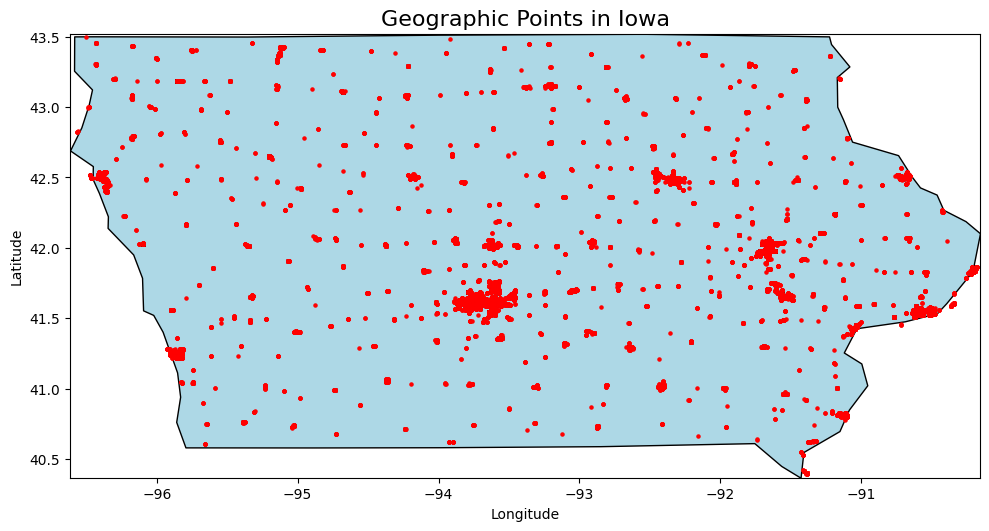

In [445]:
import geopandas as gpd, matplotlib.pyplot as plt
from shapely.geometry import Point

frame = pd.read_csv('/content/BQ_liquor_sales_cleaned.csv')

df = frame.copy(deep = True)

df['Store_Location'] = df['Store_Location'].str.strip('POINT()')
df[['longitude', 'latitude']] = df['Store_Location'].str.split(' ', expand=True)
df['longitude'] = df['longitude'].astype(float)
df['latitude'] = df['latitude'].astype(float)

data = {'latitude': df['latitude'], 'longitude': df['longitude']}
df_coordinates = pd.DataFrame(data)

df_coordinates['geometry'] = df_coordinates.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df_coordinates, geometry = 'geometry')

# Load the states shapefile
states = gpd.read_file("ne_110m_admin_1_states_provinces.shp")

# Filter for Iowa
iowa = states[states.name == "Iowa"]

# Define the extent for zooming
minx, miny, maxx, maxy = iowa.total_bounds # Use Iowa's boundaries for initial zoom

# Plot the map of Iowa
fig, ax = plt.subplots(figsize = (10, 10))  # Adjust figure size as needed
iowa.plot(ax = ax, color='lightblue', edgecolor='black')

gdf.plot(ax = ax, color='red', markersize = 5)

ax.set_xlim(minx, maxx)  # Set x-axis limits
ax.set_ylim(miny, maxy)  # Set y-axis limits

# Set title and labels
ax.set_title("Geographic Points in Iowa", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()

###---

**Main intent of this work was to demonstrate how NaNs are to be handled when their rows can't simply be dropped. Let's end this work by answering a data analysis question.**

### Filter all records of whisky (or whiskey or scotch) sales post Jan 2024.

In [444]:
def check_whisky(whisky_name):    # Fn to check if val in 'item_description' col contains listed substrings
  return any(word in whisky_name for word in ['WHISKY', 'WHISKEY', 'SCOTCH', 'MALT', 'BOURBON'])

df = pd.read_csv('/content/BQ_liquor_sales_cleaned.csv', parse_dates = ['Order_Date'], date_format = '%Y-%m-%d')

ans = df[df['Item_Description'].apply(check_whisky) & (df['Order_Date'] > 'Jan-2024')]
ans[['Order_Date', 'Item_Description', 'Volume_Sold_Liters', 'Sale_Dollars']]

,Order_Date,Item_Description,Volume_Sold_Liters,Sale_Dollars
11,2024-01-17,FIREBALL CINNAMON WHISKEY,-9.60,-144.00
25,2024-10-04,FIREBALL CINNAMON WHISKEY,-3.00,-54.00
65,2024-07-01,FIREBALL CINNAMON WHISKEY PARTY BUCKET,0.05,77.40
66,2024-03-25,FIREBALL CINNAMON WHISKEY PARTY BUCKET,0.05,77.40
70,2025-01-29,FIREBALL CINNAMON WHISKEY PARTY BUCKET,0.05,78.60
...,...,...,...,...
28716,2024-04-03,CLAN MACGREGOR SCOTCH,1.00,9.99
29235,2024-06-26,SKREWBALL PEANUT BUTTER WHISKEY,1.00,28.47
29498,2024-04-11,CANADIAN LTD WHISKY,1.12,10.14
29569,2024-02-26,1792 SMALL BATCH BOURBON,1.12,28.14


---
**KEEPING ALL DATA LOADING & TRANSFORMATION LOGIC IN ONE CELL FOR QUICK RUN IN CASE OF ABRUPT SESSION TERMINATION**

In [441]:
# import pandas as pd

# # -------------- Creating custom fn to shift columns around in frame -------------------------
# # main_col : col beside which new columns will be shifted
# # mover_cols_list : newly created cols that need shifting beside main_col in L2R order
# # df_main : main dataframe ('df')

# def shift_columns(df_main, main_col, mover_cols_list):
#   all_cols_list = df_main.columns.tolist()  # Listing current df columns
#   main_col_pos  = df_main.columns.get_loc(main_col)   # '.get_loc()' returns 0-based index of col in df

#   for col in mover_cols_list:
#     all_cols_list.insert(main_col_pos + 1, all_cols_list.pop(all_cols_list.index(col)))
#     main_col_pos += 1    # Shifting the index of col pos towards right in df

#   return df_main[all_cols_list]
# # ---------------------------------------------------------------------------------------------

# df = pd.read_csv('/content/BQ_liquor_sales_data.csv')
# pd.set_option('display.max_columns', df.shape[1])

# df.index += 1 # Resetting the index to start from 1

# df.columns = ['_'.join(word.title() for word in col.split('_')) for col in df.columns] # Setting column names to title-case
# df.rename(columns = {'Invoice_And_Item_Number' : 'Bill_Number', 'Date' : 'Order_Date'}, inplace = True)  # Renaming columns

# df['Order_Date'] = pd.to_datetime(df['Order_Date'], format = '%Y-%m-%d')  # Changing dtype
# # df['Order_Date'].dtype  # dtype('<M8[ns]')

# # Extracting date component's into new cols
# df['Order_Year'] = df['Order_Date'].dt.year
# df['Order_Month'] = df['Order_Date'].dt.month
# df['Order_Day'] = df['Order_Date'].dt.day
# df['Order_Quarter'] = df['Order_Date'].dt.quarter
# df = shift_columns(df, 'Order_Date', df.columns[-4:])  # Shifting the newly creating columns

# df.drop(columns = ['Address', 'Category', 'Vendor_Number', 'Volume_Sold_Gallons'], inplace = True) # Dropping cols

# pd.set_option('display.max_columns', df.shape[0])
# df.head(2)